In [1]:
from train import train_model
from utils import load_config, load_model, inference
from utils import visualize_output, get_keypoints_from_heatmaps
import cv2
import numpy as np
from dataset import PoseDataset
import torch

In [3]:
config = load_config('./config_w48_384x288.yaml')
config['model']['weights'] = 'runs/20240918_205337/checkpoint_epoch_5/weights_epoch_5.pth'

In [4]:
dataset = PoseDataset(config["dataset"], config["dataset"]['val'])
# get one sample from the dataset
# image,target,keypoints_gt,keypoint_visibility = dataset[334]
# image,target,keypoints_gt,keypoint_visibility = dataset[632]
image,target,keypoints_gt,keypoint_visibility = dataset[191]

In [4]:
# image = cv2.imread("./example_images/demo_cropped.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (384, 288))
# image = image.transpose(2, 0, 1)
# image = image.astype(np.float32)
# image /= 255.0

# image = torch.tensor(image)

In [11]:
result = inference(config, image.unsqueeze(0))

keypoints = get_keypoints_from_heatmaps(result, (image.shape[1], image.shape[2]))

In [ ]:
config = load_config('./config_w48_384x288.yaml')
result = inference(config, image.unsqueeze(0))

keypoints_org = get_keypoints_from_heatmaps(result, (image.shape[1], image.shape[2]))
print(image.shape)

In [ ]:
import matplotlib.pyplot as plt

image_show = image.permute(1,2,0).numpy()
# image_show = cv2.cvtColor(image_show, cv2.COLOR_RGB2BGR)


for i in range(keypoints_org.shape[1]):
    cv2.circle(image_show, (int(keypoints_org[0][i][0]), int(keypoints_org[0][i][1])), 3, (0,0,255), -1)

for i in range(len(keypoints_gt)):
    cv2.circle(image_show, (int(keypoints_gt[i][0]), int(keypoints_gt[i][1])), 3, (0,255,0), -1)

for i in range(keypoints.shape[1]):
    cv2.circle(image_show, (int(keypoints[0][i][0]), int(keypoints[0][i][1])), 2, (255,0,0), -1)

# add labels
cv2.putText(image_show, 'Ground Truth', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)
cv2.putText(image_show, 'Predicted', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
cv2.putText(image_show, 'Predicted Org', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)

# show image in notebook cell with matplotlib
plt.imshow(image_show)
plt.show()

In [ ]:
import pandas as pd
df = pd.read_csv('./data/cropped.csv')

widths = df['box_w']
heights = df['box_h']

print(widths.mean(), heights.mean())
print(min(widths), max(widths))
print(min(heights), max(heights))

In [ ]:
image = cv2.imread("./data/cropped/cropped_C1S1A1D1_0818.jpg")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# size = (576, 768)
# size = (288, 384)
size = (192, 256)
image = cv2.resize(image, size)

# config = load_config('./config_w48_384x288.yaml')
# config = load_config('./config_ViT_B_simple.yaml')
config = load_config('./config_ViT_B_classic.yaml')

image = torch.tensor(image).float()
image /= 255.0
image = image.permute(2,0,1)
image = image.unsqueeze(0)

result = inference(config, image)

keypoints = get_keypoints_from_heatmaps(result, (image.shape[2], image.shape[3]))

In [ ]:
import matplotlib.pyplot as plt


heatmaps = result[0].cpu().detach().numpy()

image_show = cv2.imread("./data/cropped/cropped_C1S1A1D1_0818.jpg")
image_show = cv2.cvtColor(image_show, cv2.COLOR_BGR2RGB)
image_show = cv2.resize(image_show, size)

heatmap = np.sum(heatmaps, axis=0)
heatmap = cv2.resize(heatmap, size)
# heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap *= 255
heatmap = heatmap.astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)
image_show = cv2.addWeighted(heatmap, 0.5, image_show, 0.5, 0)

for i in range(keypoints.shape[1]):
    cv2.circle(image_show, (int(keypoints[0][i][0]), int(keypoints[0][i][1])), 3, (0,0,255), -1)


plt.imshow(image_show)
plt.show()

Visualise different keypoint sets

In [13]:
import numpy as np
from dataset import PoseDataset
import torch
from utils import load_config, load_model, inference, draw_keypoints
import matplotlib.pyplot as plt
import cv2

config = load_config('./configs/config_w32_256x192.yaml')
img_size = (300, 400)
config['dataset']['preprocess']['input_size'] = img_size

config['dataset']['keypoints'] = 'small_17'
dataset_17 = PoseDataset(config["dataset"], config["dataset"]['val'])

config['dataset']['keypoints'] = 'med_34'
dataset_34 = PoseDataset(config["dataset"], config["dataset"]['val'])

config['dataset']['keypoints'] = 'all_63'
dataset_63 = PoseDataset(config["dataset"], config["dataset"]['val'])

In [37]:
def show_keypoints(dataset, n, color=(0,255,0)):
    image, target, keypoints_gt, keypoint_visibility = dataset[n]
    keypoints_gt = torch.tensor(keypoints_gt)
    keypoint_visibility = torch.tensor(keypoint_visibility)
    image_show = image.permute(1,2,0).numpy()
    image_show *= 255
    image_show = image_show.astype(np.uint8)
    image_show = cv2.cvtColor(image_show, cv2.COLOR_RGB2BGR)

    image_show = draw_keypoints(image_show, keypoints_gt, keypoint_visibility, color)

    return image_show.copy()

In [ ]:
n_f = 3174
n_b = 2540
img1 = show_keypoints(dataset_17, n_f, (0,255,0))
img2 = show_keypoints(dataset_17, n_b, (0,255,0))
img = np.append(img1, img2, axis=0)
cv2.imwrite('small.jpg', img)

img1 = show_keypoints(dataset_34, n_f, (255,0,0))
img2 = show_keypoints(dataset_34, n_b, (255,0,0))
img = np.append(img1, img2, axis=0)
cv2.imwrite('med.jpg', img)

img1 = show_keypoints(dataset_63, n_f, (0,0,255))
img2 = show_keypoints(dataset_63, n_b, (0,0,255))
img = np.append(img1, img2, axis=0)
cv2.imwrite('all.jpg', img)

YOLO eval

In [1]:
from utils import load_config, normalized_mae_in_pixels
from dataset import PoseDataset
from ultralytics import YOLO
import torch
import tqdm

config = load_config('./configs/config_w32_256x192.yaml')
# img_size = (640, 640)
img_size = (480, 640)
# img_size = (960, 1280)
# img_size = (192, 256)
config['dataset']['preprocess']['input_size'] = img_size

n = 64
dataset = PoseDataset(config["dataset"], config["dataset"]['val'])

loader = torch.utils.data.DataLoader(dataset, batch_size=n, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = YOLO('./models/YOLO/runs/pose/train9/weights/best.pt').to(device)
# model = YOLO('./weights/yolov8x-pose.pt').to(device)

In [2]:
def get_keypoints_yolo(outputs, num_keypoints=17):
    keypoints = []
    for output in outputs:
        xy = output.keypoints.xy[0]
        if xy.shape[0] < num_keypoints:
            xy = torch.cat((xy, torch.zeros(num_keypoints - xy.shape[0], 2).to(xy.device)))
        keypoints.append(xy)
    
    return torch.stack(keypoints)

In [ ]:
norm_mae = 0
keypoints = None
with torch.no_grad():
    for images, targets, gt_keypoints, keypoint_visibility in tqdm.tqdm(loader):
        images, targets = images.to(device), targets.to(device)
        gt_keypoints = gt_keypoints.to(device)
        keypoint_visibility = keypoint_visibility.to(device)
        outputs = model(images, verbose=False)
        keypoints = get_keypoints_yolo(outputs, num_keypoints=17)
        norm_mae += normalized_mae_in_pixels(keypoints, gt_keypoints, img_size, keypoint_visibility)
    
norm_mae /= len(loader)

In [ ]:
print(norm_mae)

In [ ]:
import matplotlib.pyplot as plt

n = 20

image_show = images[n].permute(1,2,0).cpu().numpy().copy()

keypoints_show = keypoints[n].cpu().numpy()
keypoints_gt = gt_keypoints[n].cpu().numpy()

plt.imshow(image_show)
plt.plot(keypoints_show[:,0], keypoints_show[:,1], 'bo', markersize=3)
plt.plot(keypoints_gt[:,0], keypoints_gt[:,1], 'go', markersize=3)
plt.show()

In [ ]:
from utils import load_config, load_model
import time
from dataset import PoseDataset
import torch

config = load_config('./configs/config_w48_768x576.yaml')


n = 10
images = torch.randn(n, 3, 768, 576)

device = 'cuda:0'
device = torch.device(device)

model = load_model(config['model']).to(device)


with torch.no_grad():
    images = images.to(device)
    start = time.time()
    outputs = model(images)
    end = time.time()
    avg_time = ((end - start) / n) * 1000


print(f'Average inference time: {avg_time} ms')

In [ ]:
from ultralytics import YOLO
import statistics
import torch
import time

model = YOLO('./weights/yolov8x-pose-p6.pt')

device = 'cuda:0'
device = torch.device(device)

model = model.to(device)

n = 10

# generate random images
images = torch.rand((n, 3, 1280, 1280))

# measure inference time
with torch.no_grad():
    images = images.to(device)
    start = time.time()
    outputs = model(images)
    end = time.time()
    avg_time = ((end - start) / n) * 1000

print(f'Average inference time: {avg_time} ms')


In [ ]:
from dataset import PoseDataset
from utils import load_config, load_model
from train import validate
from utils import JointsMSELoss
import torch
from torch.utils.data import DataLoader

config = load_config('./configs/config_w48_384x288.yaml')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = config["dataset"]["preprocess"]["input_size"]
batch_size = config["training"]["batch_size"]

run = '20240930_114636'
epoch = 3
config['model']['weights'] = f'runs/{run}/checkpoint_epoch_{epoch}/weights_epoch_{epoch}.pth'

model = load_model(config['model'])
model = model.to(device)

val_dataset = PoseDataset(config["dataset"], config["dataset"]['val'])

val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )

criterion = JointsMSELoss()
val_loss, norm_mae = validate(model, val_loader, criterion, device, input_size)
print(f'Validation loss: {val_loss}, Normalized MAE: {norm_mae}')

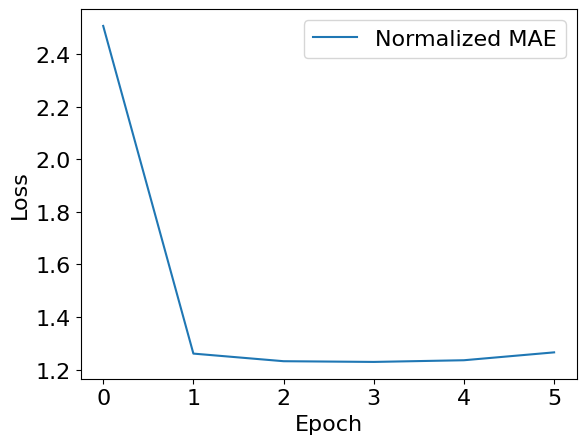

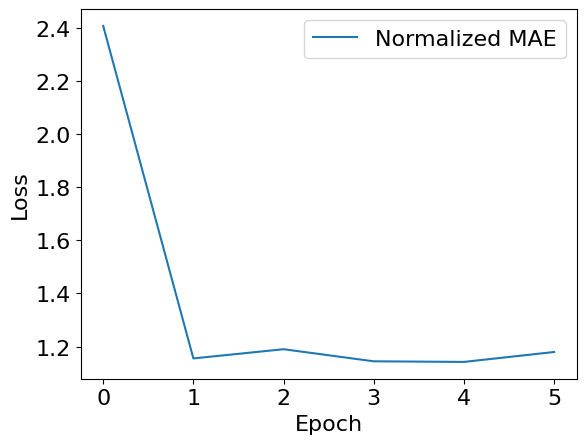

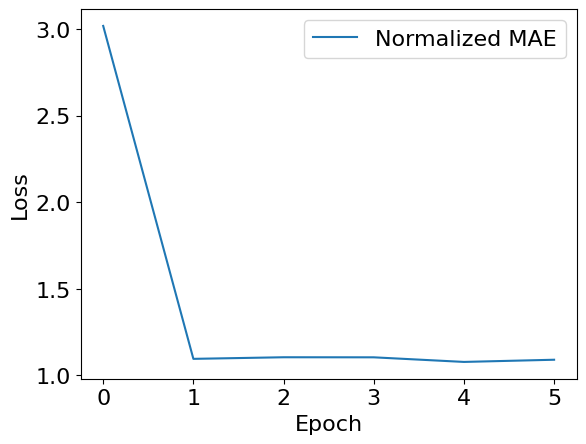

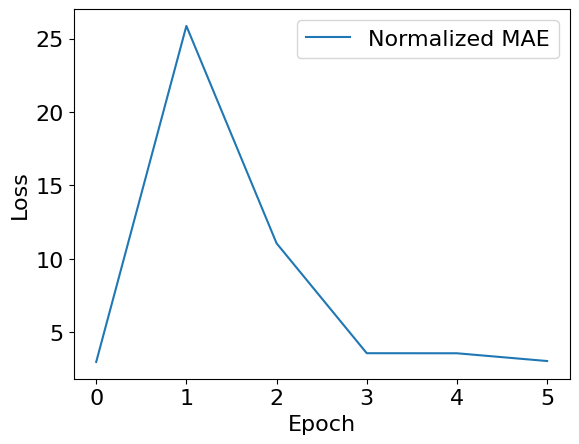

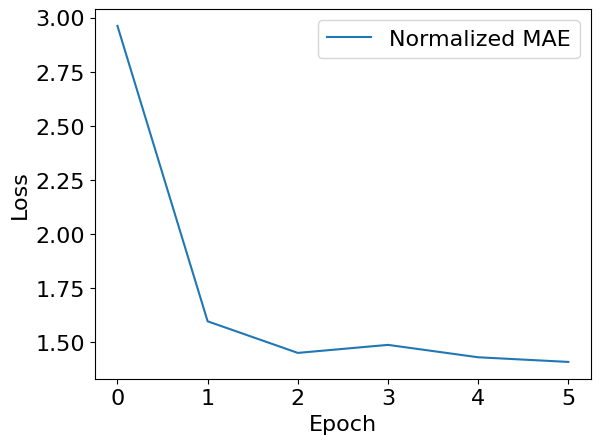

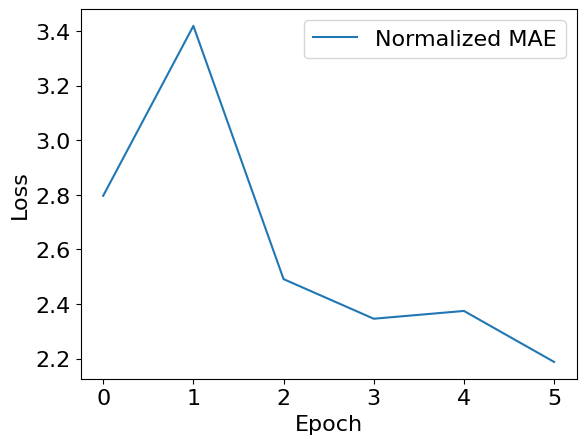

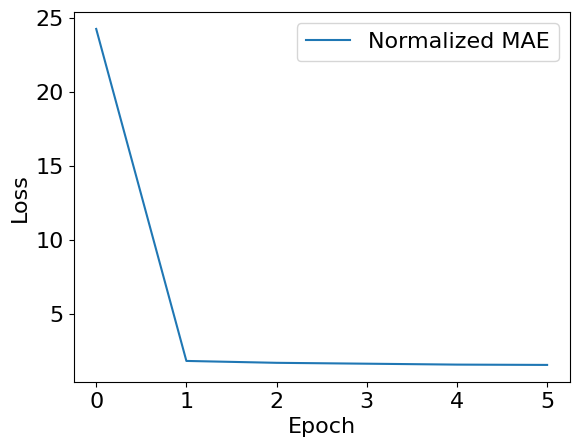

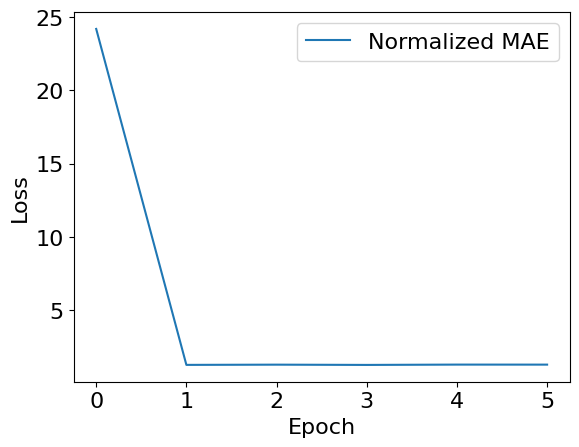

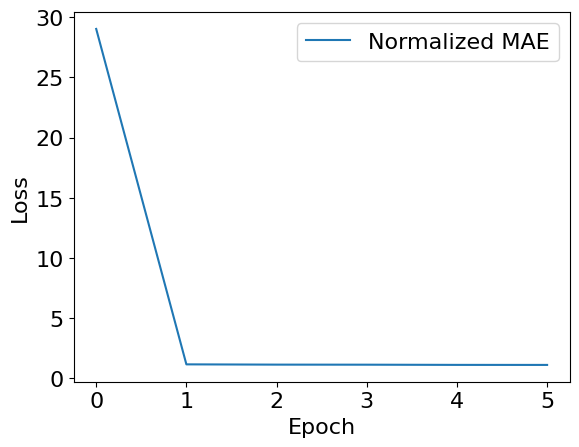

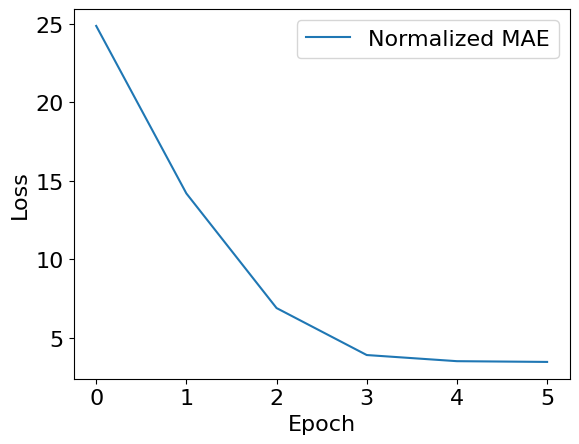

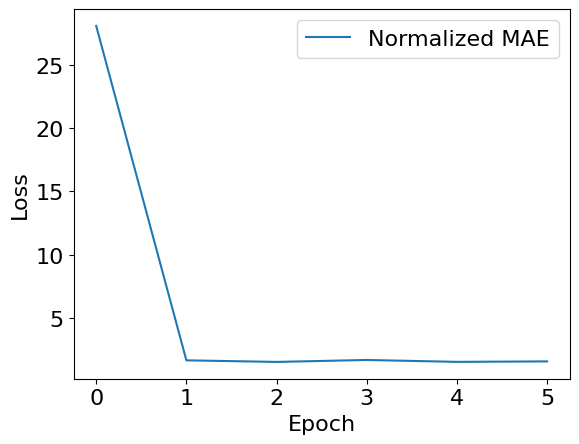

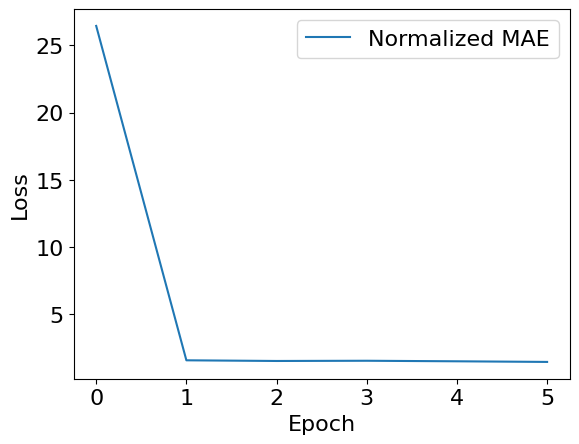

In [1]:
import json
import matplotlib.pyplot as plt
import yaml

runs_17 = {
    "HRNet-w32-192x256":"20240930_095845",
    "HRNet-w48-288x384":"20240930_104432",
    "HRNet-w48-576x768":"20241016_095811",
    "ViTPose-B-simple":"20240930_135730",
    "ViTPose-B-classic":"20240930_160118",
    "ViTPose-L-classic":"20241016_174317"
}
runs_34 = {
    "HRNet-w32-192x256":"20240930_101955",
    "HRNet-w48-288x384":"20240930_114636",
    "HRNet-w48-576x768":"20241016_122545",
    "ViTPose-B-simple":"20240930_153334",
    "ViTPose-B-classic":"20240930_164507",
    "ViTPose-L-classic":"20241016_182442"
}

def plot_run(run, model, keypoint_count=17):
    # config = yaml.load(open(f'runs/{run}/config.yaml', 'r'), Loader=yaml.FullLoader)

    with open(f'runs/{run}/training_results.json', 'r') as f:
        results = json.load(f)

        epochs = results['epochs']
        epochs[0]['train_loss'] = None
        train_losses = [epoch['train_loss'] for epoch in epochs]
        val_losses = [epoch['val_loss'] for epoch in epochs]
        norm_maes = [epoch['normalized_mae'] for epoch in epochs]

        plt.rcParams.update({'font.size': 16})
        
        # plt.plot(train_losses, label='Train Loss')
        # plt.plot(val_losses, label='Validation Loss')
        plt.plot(norm_maes, label='Normalized MAE')
        # plt.title(f'{model} - {keypoint_count} keypoints')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # plt.savefig(f'figs/{model}-{keypoint_count}.pdf')
        plt.show()


for model, run in runs_17.items():
    plot_run(run, model)

for model, run in runs_34.items():
    plot_run(run, model, 34)

In [ ]:
import csv

yolo_runs_17 = {
    'YOLOv8n-pose': "train",
    'YOLOv8x-pose': "train4",
    'YOLOv8x-pose-p6': "train5"
}
yolo_runs_34 = {
    'YOLOv8n-pose': "train7",
    'YOLOv8x-pose': "train6",
    'YOLOv8x-pose-p6': "train8"
}


def plot_yolo_run(run, model, keypoint_count=17):
    results = csv.reader(open(f'models/YOLO/runs/pose/{run}/results.csv', 'r'))
    next(results)
    train_losses = []
    val_losses = []

    for row in results:
        train_losses.append(float(row[2]))
        val_losses.append(float(row[15]))

    epochs = range(1, len(train_losses) + 1)
    plt.rcParams.update({'font.size': 16})
    plt.plot(epochs,train_losses, label='Train Loss')
    plt.plot(epochs,val_losses, label='Validation Loss')
    plt.xticks(range(1, len(train_losses)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'figs/{model}-{keypoint_count}.pdf')
    plt.show()

for model, run in yolo_runs_17.items():
    plot_yolo_run(run, model)

for model, run in yolo_runs_34.items():
    plot_yolo_run(run, model, 34)